# Visualize message duplication for each group of Twitterers (government entities / health organizations / news outlets / social media influencers / other)
#### Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
!pip uninstall -y nltk



Found existing installation: nltk 3.6.4
Uninstalling nltk-3.6.4:
  Successfully uninstalled nltk-3.6.4


In [4]:
pip install -U nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 43.7 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
Note: you may need to restart the kernel to use updated packages.


In [4]:
import re
import os
import shutil
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row


In [5]:
from pyspark.sql import functions as F


In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [8]:
tweets_spark = spark.read.parquet('gs://' + 'msca-bdp-students-bucket' + '/shared_data/sanchit/tweetsonemillion')


In [9]:
tweets_spark.columns
#confirmation

['created_at',
 'statuses_count',
 'retweeted',
 'text',
 'user_id',
 'username',
 'user_desc',
 'followers_count',
 'location',
 'verified_user']

#### Implement classification of types of organizations (news, non-profit, university/school, private institutions, individuals)

In [10]:
tweets_classification_df = tweets_spark.\
withColumn('news_org',
    F.when((F.col("username").contains('news')) \
           | (F.col("user_desc").contains('news'))\
           | (F.col("user_desc").contains('network'))\
                      | (F.col("user_desc").contains('network'))\
           | (F.col("user_desc").contains('publication')),"true")).\
withColumn('nonprofit',
    F.when((F.col("username").contains('nonprofit')) \
           | (F.col("user_desc").contains('nonprofit'))\
           | (F.col("user_desc").contains('non-profit'))\
           | (F.col("user_desc").contains('initative'))
           | (F.col("user_desc").contains('non-partisan'))\
           | (F.col("user_desc").contains('poverty'))\
           | (F.col("user_desc").contains('program'))\
           | (F.col("user_desc").contains('charter')),"true")).\
withColumn('university_school',
    F.when((F.col("username").contains('university')) \
           | (F.col("username").contains('school'))\
           | (F.col("user_desc").contains('university'))\
           | (F.col("user_desc").contains('school'))
           | (F.col("user_desc").contains('uni'))\
           | (F.col("user_desc").contains('college')),"true")).\
withColumn('private_institution',
    F.when((F.col("username").contains('.com')) \
           | (F.col("username").contains('group'))\
           | (F.col("user_desc").contains('marketing'))\
           | (F.col("user_desc").contains('finance'))\
           | (F.col("user_desc").contains('ad'))\
           | (F.col("user_desc").contains('job'))\
           | (F.col("user_desc").contains('networking'))\
           | (F.col("user_desc").contains('tutoring'))\
           | (F.col("user_desc").contains('financial'))\
           | (F.col("user_desc").contains('fund'))\
                      | (F.col("user_desc").contains('advertiser'))\
           | (F.col("user_desc").contains('tutor')),"true"))

In [11]:
tweets_classification_df = tweets_classification_df.\
withColumn('influencers',
    F.when((F.col("verified_user") == 'true') & ((F.col("followers_count") >= 50000)),"true").otherwise("false"))

#influencers are verified users with more than 50000 followers

In [12]:
news_org_count = tweets_classification_df.filter(tweets_classification_df.news_org == 'true').count()
news_org_count
news_org_df = tweets_classification_df.filter(tweets_classification_df.news_org == 'true')

In [13]:
nonprofit_count = tweets_classification_df.filter(tweets_classification_df.nonprofit == 'true').count()
nonprofit_count
nonprofit_df = tweets_classification_df.filter(tweets_classification_df.nonprofit == 'true')


In [14]:
university_school_count = tweets_classification_df.filter(tweets_classification_df.university_school == 'true').count()
university_school_count
university_school_df = tweets_classification_df.filter(tweets_classification_df.university_school == 'true')

In [13]:
influencers_count = tweets_classification_df.filter(tweets_classification_df.influencers == 'true').count()
influencers_count
influencers_df = tweets_classification_df.filter(tweets_classification_df.influencers == 'true')

# News Organizations Message Duplication

In [16]:
tweets_spark_limit = news_org_df.limit(5000)

In [17]:
from pyspark.sql import functions as F


In [18]:
textdf = tweets_spark_limit.select(F.substring('text',1,50).alias("text"))
textdf.limit(5)

text
#Students in @Peo...
.@MdPublicSchools...
RT @ProfeDeAngelo...
Post UTME Form Fo...
RT @UofGHeadship:...


In [19]:
body_text = textdf.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = body_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [20]:
row = Row('text')
text_df = body_text.map(row).zipWithIndex().toDF(['text','id'])

In [21]:
text_df.limit(5)

text,id
{#Students in @Pe...,0
{.@MdPublicSchool...,1
{RT @ProfeDeAngel...,2
{Post UTME Form F...,3
{RT @UofGHeadship...,4


In [22]:
text_df.count()

5000

In [23]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[#students, in, @peoriaunified11, edcamp, #students, do]",0
1,"[.@mdpublicschools, has, launched, $193, million, gran]",1
2,"[rt, @profedeangelo:, potentially, unpopular, opinion:]",2
3,"[post, utme, form, for, kwara, state, college, of, educatio]",3
4,"[rt, @uofgheadship:, fantastic, opportunity, to, join]",4


### Step 2. Fit countvectorizer to create word features

In [24]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [69]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[#students, in, @peoriaunified11, edcamp, #students, do]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[.@mdpublicschools, has, launched, $193, million, gran]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, @profedeangelo:, potentially, unpopular, opinion:]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[post, utme, form, for, kwara, state, college, of, educatio]",3,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @uofgheadship:, fantastic, opportunity, to, join]",4,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Step 3. Fit MinHashLSH to create hash table


In [25]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [26]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left') 
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
26,{RT @TabitaSurge:...,"[rt, @tabitasurge...","(10996,[0,10,18,4...","[[4.7945584E7], [..."
29,{AAA’s commitment...,"[aaa’s, commitmen...","(10996,[3,80,965,...","[[3.52728429E8], ..."
474,{RT @Mr_JAGs: I w...,"[rt, @mr_jags:, w...","(10996,[0,7,22,12...","[[4.7945584E7], [..."
964,{ICYMI: The abrup...,"[icymi:, the, abr...","(10996,[1,3,5,12,...","[[3.4717271E8], [..."
1677,{RUHS Nursing Exa...,"[ruhs, nursing, e...","(10996,[3,78,574,...","[[2.3221685E7], [..."


In [27]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            F.col("distCol"),
            F.col("datasetA.id").alias("id_A"),
            F.col("datasetB.id").alias("id_B"),
            F.col('datasetA.text').alias('text_A'),
            F.col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

df_dups_30 = df_dups_text

In [28]:
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.375000,3233,4872,"(Best Universities for Blockchain 2022: University ,)","(Best Universities for Blockchain 2022: King Saud U,)"
1,0.000000,4631,4633,"(Under the law, a curriculum about communist regime,)","(Under the law, a curriculum about communist regime,)"
2,0.300000,4411,4412,"(@SarahColburn8 My name is Ashley Lawrence and I am,)","(@lissarod10 My name is Ashley Lawrence and I am Sc,)"
3,0.000000,3347,4542,"(RT @POTUS: It's time we ban assault weapons so our,)","(RT @POTUS: It's time we ban assault weapons so our,)"
4,0.444444,3224,4872,"(Best Universities for Blockchain 2022: Carnegie Me,)","(Best Universities for Blockchain 2022: King Saud U,)"


In [29]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate text based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique text based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  5000
Duplicate text based on { 0.5 } jaccard distance:  416
Unique text based on { 0.5 } jaccard distance:  0.5 :  4584


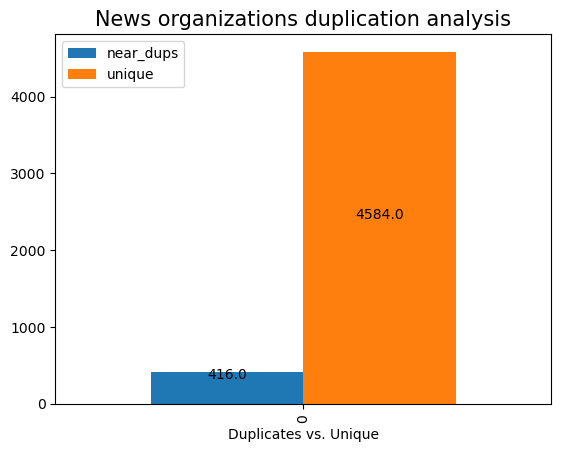

In [30]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News organizations duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

# Nonprofit Organizations Message Duplication

In [16]:
tweets_spark_limit = nonprofit_df.limit(5000)

In [17]:
textdf = tweets_spark_limit.select(F.substring('text',1,50).alias("text"))
textdf.limit(5)

text
We believe that C...
The Bus Grant ($5...
#ProjectGirlsOnTh...
RT @ShwetaKukreja...
It's time for som...


In [18]:
body_text = textdf.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = body_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [19]:
row = Row('text')
text_df = body_text.map(row).zipWithIndex().toDF(['text','id'])

In [20]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[we, believe, that, customized, curriculum, benefits, #te]",0
1,"[the, bus, grant, ($500), and, art, supplies, grant, ($1500]",1
2,"[#projectgirlsontherise, applications, close, today]",2
3,"[rt, @shwetakukreja_:, yes,, education, is, free., but, no]",3
4,"[it's, time, for, some, more, trivia!, comment, in, the, thr]",4


### Step 2. Fit countvectorizer to create word features

In [21]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [52]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[we, believe, that, customized, curriculum, benefits, #te]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[the, bus, grant, ($500), and, art, supplies, grant, ($1500]",1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[#projectgirlsontherise, applications, close, today]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, @shwetakukreja_:, yes,, education, is, free., but, no]",3,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[it's, time, for, some, more, trivia!, comment, in, the, thr]",4,"(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Step 3. Fit MinHashLSH to create hash table


In [22]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [23]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left') 
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
26,{RT @roshinifer33...,"[rt, @roshinifer3...","(10796,[0,2,22,57...","[[4.7945584E7], [..."
29,{RT @SchottHappen...,"[rt, @schotthappe...","(10796,[0,6,283,5...","[[4.7945584E7], [..."
474,{RT @daddyhope: S...,"[rt, @daddyhope:,...","(10796,[0,1,3,16,...","[[4.7945584E7], [..."
964,{Days after the a...,"[days, after, the...","(10796,[1,16,102,...","[[2027525.0], [3...."
1677,{RT @bencasselman...,"[rt, @bencasselma...","(10796,[0,1,43,44...","[[4.7945584E7], [..."


In [24]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            F.col("distCol"),
            F.col("datasetA.id").alias("id_A"),
            F.col("datasetB.id").alias("id_B"),
            F.col('datasetA.text').alias('text_A'),
            F.col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

df_dups_30 = df_dups_text

In [25]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate text based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique text based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  5000
Duplicate text based on { 0.5 } jaccard distance:  379
Unique text based on { 0.5 } jaccard distance:  0.5 :  4621


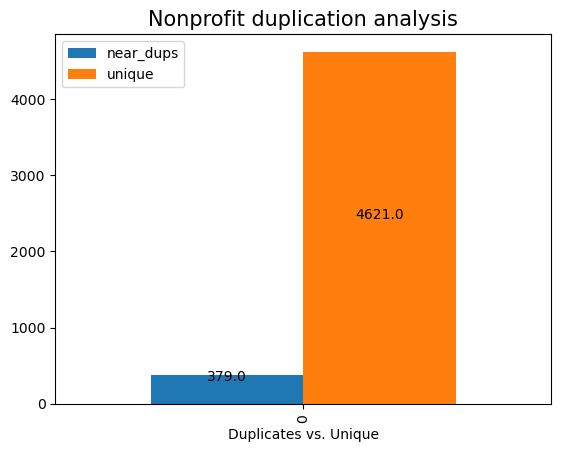

In [26]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Nonprofit duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

# University / School Message Duplication 


In [27]:
tweets_spark_limit = university_school_df.limit(5000)

In [28]:
textdf = tweets_spark_limit.select(F.substring('text',1,50).alias("text"))
textdf.limit(5)

text
RT @EduRankAndFil...
RT @FierceEducati...
"""The Education Mi..."
RT @College_Promi...
University News |...


In [29]:
body_text = textdf.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = body_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [30]:
row = Row('text')
text_df = body_text.map(row).zipWithIndex().toDF(['text','id'])

In [31]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @edurankandfile:, the, pandemic, has, vastly, accele]",0
1,"[rt, @fierceeducation:, league, for, innovation, in, the]",1
2,"[""the, education, ministry, said, the, government, will]",2
3,"[rt, @college_promise:, not, all, careers, require, tra]",3
4,"[university, news, congratulations, to, @uwconline, fo]",4


### Step 2. Fit countvectorizer to create word features

In [32]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

### Step 3. Fit MinHashLSH to create hash table


In [33]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [34]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left') 
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
26,{RT @ACE_Howe: Ar...,"[rt, @ace_howe:, ...","(11260,[0,6,72,51...","[[4.7945584E7], [..."
29,{Last week we vis...,"[last, week, we, ...","(11260,[13,100,14...","[[3.45154593E8], ..."
474,{My work from Una...,"[my, work, from, ...","(11260,[5,10,28,3...","[[3.4717271E8], [..."
964,{Give to a School...,"[give, to, school...","(11260,[2,8,9,108...","[[1.4642722E7], [..."
1677,{RT @GlobeEducati...,"[rt, @globeeducat...","(11260,[0,1,5,356...","[[4.7945584E7], [..."


In [35]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            F.col("distCol"),
            F.col("datasetA.id").alias("id_A"),
            F.col("datasetB.id").alias("id_B"),
            F.col('datasetA.text').alias('text_A'),
            F.col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

df_dups_30 = df_dups_text

In [36]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate text based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique text based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  5000
Duplicate text based on { 0.5 } jaccard distance:  408
Unique text based on { 0.5 } jaccard distance:  0.5 :  4592


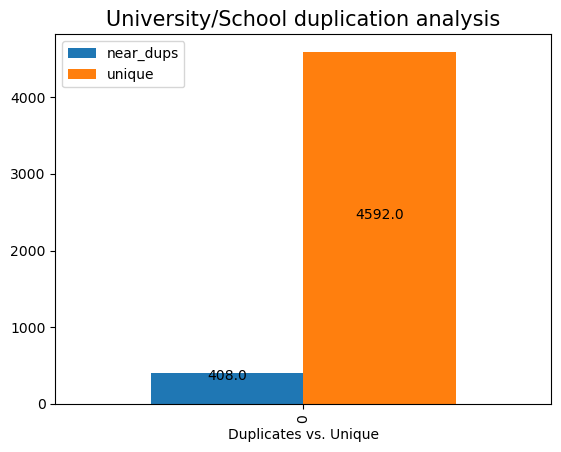

In [37]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('University/School duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

# Influencer Message Duplication 


In [14]:
tweets_spark_limit = influencers_df.limit(5000)

In [15]:
textdf = tweets_spark_limit.select(F.substring('text',1,50).alias("text"))
textdf.limit(5)

text
KZN Education MEC...
RT @EduCannotWait...
RT @kyjpdavis: Mo...
Kamrup Metro Depu...
Real question: Wh...


In [16]:
body_text = textdf.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = body_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [17]:
row = Row('text')
text_df = body_text.map(row).zipWithIndex().toDF(['text','id'])

In [18]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[kzn, education, mec, confident, that, learning, will, res]",0
1,"[rt, @educannotwait:, #ecw, strives, to, reach, every, vul]",1
2,"[rt, @kyjpdavis:, modern, day, education, assignment, at]",2
3,"[kamrup, metro, deputy, commissioner, pallav, gopal, jha]",3
4,"[real, question:, what, happens, to, medical, school, educ]",4


### Step 2. Fit countvectorizer to create word features

In [19]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

### Step 3. Fit MinHashLSH to create hash table


In [20]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [21]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left') 
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
26,{RT @narendramodi...,"[rt, @narendramod...","(10517,[0,1,4,61,...","[[4.7945584E7], [..."
29,{RT @narendramodi...,"[rt, @narendramod...","(10517,[0,1,4,61,...","[[4.7945584E7], [..."
474,{Fulton County Sc...,"[fulton, county, ...","(10517,[2,6,11,13...","[[5.75251383E8], ..."
964,{#ScholarshipAler...,[#scholarshipaler...,"(10517,[2,148,472...","[[1.69554825E8], ..."
1677,"{Yes, and thanks ...","[yes,, and, thank...","(10517,[2,9,73,76...","[[7.1680082E7], [..."


In [22]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            F.col("distCol"),
            F.col("datasetA.id").alias("id_A"),
            F.col("datasetB.id").alias("id_B"),
            F.col('datasetA.text').alias('text_A'),
            F.col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

df_dups_30 = df_dups_text

In [23]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate text based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique text based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  5000
Duplicate text based on { 0.5 } jaccard distance:  427
Unique text based on { 0.5 } jaccard distance:  0.5 :  4573


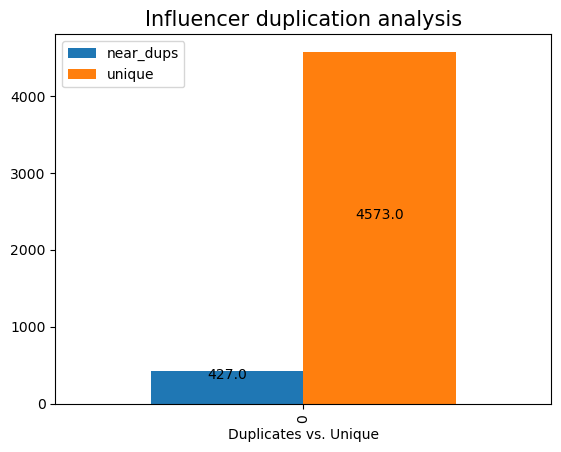

In [24]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Influencer duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 